<a href="https://colab.research.google.com/github/Kushagratandon12/Machine-Learning-Projects/blob/master/Quick_Draw_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # !gsutil -m cp 'gs://quickdraw_dataset/full/simplified/*.ndjson' . - Complete Dataset For Drawing Detection
# !gsutil -m cp 'gs://quickdraw_dataset/full/numpy_bitmap/The Eiffel Tower.npy' .
# !gsutil -m cp 'gs://quickdraw_dataset/full/simplified/The Eiffel Tower.ndjson' .
# # !gsutil -m cp 'gs://quickdraw_dataset/full/simplified/animal migration.ndjson' .

In [44]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import random
import json
import gc
import matplotlib.pyplot as plt
import warnings
!pip install cairocffi
import cairocffi as cairo

In [35]:
data = map(json.loads, open('/content/The Eiffel Tower.ndjson'))
df_data = pd.DataFrame(data)
df_data = df_data [df_data['recognized']==True]
df_data.head()

,word,countrycode,timestamp,recognized,key_id,drawing
0,The Eiffel Tower,GB,2017-03-11 14:47:44.05242 UTC,True,5027286841556992,"[[[0, 22, 37, 64, 255], [218, 220, 227, 228, 2..."
1,The Eiffel Tower,FR,2017-03-12 22:51:18.52595 UTC,True,5716269791707136,"[[[47, 47, 36, 26, 0, 10, 23, 46, 46, 63, 68, ..."
2,The Eiffel Tower,GB,2017-03-29 01:12:00.36798 UTC,True,5942899998982144,"[[[184, 115, 67, 57, 36, 18], [251, 103, 12, 1..."
3,The Eiffel Tower,US,2017-03-29 16:48:54.9129 UTC,True,6226163091374080,"[[[0, 187, 177, 132, 105, 79, 38, 19, 11], [24..."
4,The Eiffel Tower,GB,2017-03-04 15:50:45.19801 UTC,True,4889008825958400,"[[[0, 21, 43, 83, 97, 158, 169, 172], [162, 16..."


In [36]:
df_data.size

782598

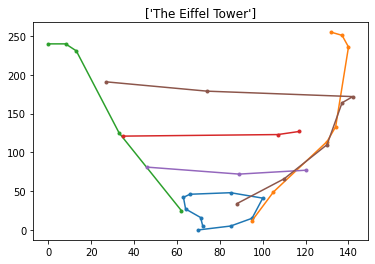

In [98]:
vector_drawings = df_data['drawing']
vector_label = df_data['word'].unique()
img_inspect = vector_drawings[random.randint(1,len(vector_drawings))]
# plt.grid(True)
for x , y in img_inspect:
  plt.plot(x, y, marker='.')
  plt.title(vector_label)

In [99]:
gc.collect()
df_data['drawing'] = df_data['drawing'].apply(json.dumps)
df_data['drawing'] = df_data['drawing'].apply(json.loads)
drawing=df_data['drawing'].values
drawing

array([list([[[0, 22, 37, 64, 255], [218, 220, 227, 228, 211]], [[76, 95, 135, 141, 150, 159, 166, 180, 186, 201], [220, 138, 31, 0, 63, 79, 117, 150, 191, 224]], [[94, 104, 111, 119, 127, 141, 143, 142, 180, 191], [212, 167, 149, 80, 59, 41, 30, 134, 202, 232]], [[109, 127, 137, 147, 150, 162, 172, 185], [122, 120, 104, 97, 99, 124, 128, 128]], [[75, 130, 158], [162, 159, 150]]]),
       list([[[47, 47, 36, 26, 0, 10, 23, 46, 46, 63, 68, 105, 107, 112, 134, 152, 170, 151, 125, 101, 82, 74, 70, 60], [18, 98, 167, 201, 255, 248, 245, 248, 235, 183, 181, 187, 202, 216, 244, 252, 239, 180, 140, 93, 42, 1, 1, 21]], [[76, 68, 78, 101, 102, 93], [71, 131, 135, 136, 126, 101]]]),
       list([[[184, 115, 67, 57, 36, 18], [251, 103, 12, 109, 193, 247]], [[145, 154, 150, 48, 24], [180, 176, 175, 178, 173]], [[55, 50, 38, 0, 28, 31, 60, 66, 71], [128, 152, 179, 253, 254, 247, 114, 26, 0]], [[72, 76, 81, 83, 86, 99, 93, 86], [26, 35, 71, 250, 255, 254, 189, 5]], [[67, 74, 97, 172], [12, 16, 49, 1

In [100]:
def vector_to_raster(vector_images, side=28, line_diameter=16, padding=16, bg_color=(0,0,0), fg_color=(1,1,1)):
    """
    padding and line_diameter are relative to the original 256x256 image.
    """
    
    original_side = 256.
    
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
    ctx = cairo.Context(surface)
    ctx.set_antialias(cairo.ANTIALIAS_BEST)
    ctx.set_line_cap(cairo.LINE_CAP_ROUND)
    ctx.set_line_join(cairo.LINE_JOIN_ROUND)
    ctx.set_line_width(line_diameter)

    # scale to match the new size
    # add padding at the edges for the line_diameter
    # and add additional padding to account for antialiasing
    total_padding = padding * 2. + line_diameter
    total_padding = padding * 2. + line_diameter
    new_scale = float(side) / float(original_side + total_padding)
    ctx.scale(new_scale, new_scale)
    ctx.translate(total_padding / 2., total_padding / 2.)

    raster_images = []
    for vector_image in vector_images:
        # clear background
        ctx.set_source_rgb(*bg_color)
        ctx.paint()
        
        bbox = np.hstack(vector_image).max(axis=1)
        offset = ((original_side, original_side) - bbox) / 2.
        offset = offset.reshape(-1,1)
        centered = [stroke + offset for stroke in vector_image]

        # draw strokes, this is the most cpu-intensive part
        ctx.set_source_rgb(*fg_color)        
        for xv, yv in centered:
            ctx.move_to(xv[0], yv[0])
            for x, y in zip(xv, yv):
                ctx.line_to(x, y)
            ctx.stroke()

        data = surface.get_data()
        raster_image = np.copy(np.asarray(data)[::4])
        raster_images.append(raster_image)
    
    return raster_images

images = vector_to_raster(drawing)
gc.collect()

0

In [110]:
imgflat = images[random.randint(1,len(images))]
img = np.reshape(imgflat,(28,28,1))
print(img.shape)

(28, 28, 1)


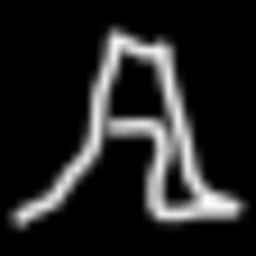

<Figure size 720x720 with 0 Axes>

In [118]:
from google.colab.patches import cv2_imshow
plt.figure(figsize=(10,10))
img = cv2.resize(img,(256,256))

kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(img,-1,kernel)

cv2_imshow(dst)

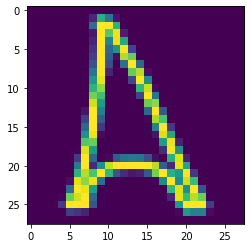

In [108]:
plt.imshow(images[random.randint(1,len(images))].reshape(28,28))